## Introduction:

The purpose of this project is to use data science tools to analyze capital bikeshare (cb) usage around 
Washington, DC before and during the COVID-19 ('coronavirus') pandemic to answer questions. Questions that come to mind include:

- What is the total number of rides since 2018?
- What are the highest (peak) and lowest (bottom) demand days/months since 2018? 
- How has total bike shared usage changed before/during COVID-19?
- Is the average ride duration shorter, longer, or the same, compared with before COVID-19?
- What bikeshare locations have the greatest difference in rides before/during COVID-19? Is there a trend/clustering to these locations? 

This brief report is seperated into 5 parts; Intro, Data Input, Data Cleaning/Processing, Data Analysis, Conclusions. See readme file on github [here] (https://github.com/mcgaritym/capital_bikeshare) for additional details.

What is Capital Bikeshare? From the company [site](https://www.capitalbikeshare.com/how-it-works):
>Capital Bikeshare is metro DC's bikeshare service, with 4,500 bikes and 500+ stations across 7 jurisdictions: Washington, DC.; Arlington, VA; Alexandria, VA; Montgomery, MD; Prince George's County, MD; Fairfax County, VA; and the City of Falls Church, VA. Designed for quick trips with convenience in mind, it’s a fun and affordable way to get around.

*Note: The pandemic begin date for this analysis is considered to be **1  Mar 2020**, since that is close to when most cities/towns started enacting protective measures. Since it is ongoing the end date is TBD, however, data is only available through 30 Jun 2020 at this time...*

## Data Input:

Data is provided by Capital Bikeshare [here](https://www.capitalbikeshare.com/system-data) on a monthly basis and provides data on all rides. Data was loaded for all 2018, 2019, and 2020 (through June) months. 


In [14]:
#load required libraries
import requests
import io
from io import BytesIO
from bs4 import BeautifulSoup
import urllib.request
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
from datetime import date, datetime
import re
import time
from urllib.request import urlopen
import zipfile
from zipfile import ZipFile
import glob
import os
from urllib.request import urlopen, Request
import seaborn as sns
import textwrap
from matplotlib import pyplot as plt
import matplotlib as mpl
import folium
from folium import plugins
from folium.plugins import HeatMap
import numpy as np

# gather files in local directory, create empty dataframe, and concatenate data
files = glob.glob('20*')
files.sort()
#print(files)
df = pd.DataFrame()
for f in files:
    data = pd.read_csv(f)
    df = pd.concat([df, data], axis=0, sort='False')

# reindex data 
df.reindex()
print('Total number of rides (2018-Present):', len(df))

Total number of rides (2018-Present): 7916731


## Data Cleaning/Processing:

In [15]:
# some files have different columns names, so the below text standardizes/fills columns, converts to datetime(if applicable), and creates new duration or number_rides column
df.reset_index(level=0, inplace=True)
df['start_station_name'].update(df.pop('Start station'))
df['end_station_name'].update(df.pop('End station'))
df['started_at'].update(df.pop('Start date'))
df['ended_at'].update(df.pop('End date'))
df['member_casual'].update(df.pop('Member type'))
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['duration'] = df['ended_at'] - df['started_at']
df['number_rides'] = 1

# drop unnecessary, redundant or blank columns
df = df.drop(columns = ['Duration', 'is_equity', 'rideable_type', 'Bike number', 'start_station_id', 'end_station_id'])

# rename columns
df[['start_lat', 'end_lat', 'start_lng', 'end_lng', 'Start station number', 'End station number']] = df[['start_lat', 'end_lat', 'start_lng', 'end_lng', 'Start station number', 'End station number']].apply(pd.to_numeric)

#convert to category data type
df[['start_station_name', 'end_station_name']] = df[['start_station_name', 'end_station_name']].apply(pd.Categorical)

# filling in missing start and end station numbers and
df['Start station number'] = df['Start station number'].fillna(df.groupby('start_station_name')['Start station number'].transform('mean'))
df['End station number'] = df['End station number'].fillna(df.groupby('end_station_name')['End station number'].transform('mean'))

# fill in missing latitude/longitude data based on other rows (same station) that have latitude/longitude
df['start_lat'] = df['start_lat'].fillna(df.groupby('Start station number')['start_lat'].transform('mean'))
df['end_lat'] = df['end_lat'].fillna(df.groupby('End station number')['end_lat'].transform('mean'))
df['start_lng'] = df['start_lng'].fillna(df.groupby('Start station number')['start_lng'].transform('mean'))
df['end_lng'] = df['end_lng'].fillna(df.groupby('End station number')['end_lng'].transform('mean'))

# rename columns
df = df.rename(columns={'Start station number': 'start_station_id', 'End station number': 'end_station_id'})

# drop rows with missing values
df = df.dropna(subset=['start_lat', 'end_lat', 'start_lng', 'end_lng', 'start_station_id', 'end_station_id', 'start_station_name', 'end_station_name'])

# print sample of data
print('Data Sample:', df.head())

Data Sample:    index  end_station_id  start_station_id    end_lat    end_lng  \
0      0         31400.0           31104.0  38.936692 -77.024190   
1      1         31321.0           31321.0  38.892208 -77.033206   
2      2         31321.0           31321.0  38.892208 -77.033206   
3      3         31103.0           31406.0  38.926093 -77.036520   
4      4         31619.0           31618.0  38.890480 -76.988377   

                            end_station_name            ended_at  \
0             Georgia & New Hampshire Ave NW 2018-01-01 00:14:18   
1              15th St & Constitution Ave NW 2018-01-01 00:35:53   
2              15th St & Constitution Ave NW 2018-01-01 00:35:58   
3                       16th & Harvard St NW 2018-01-01 00:25:09   
4  Lincoln Park / 13th & East Capitol St NE  2018-01-01 00:24:15   

  member_casual ride_id  start_lat  start_lng             start_station_name  \
0        Member     NaN  38.922913 -77.042590    Adams Mill & Columbia Rd NW   
1        

## Data Analysis

The first plot below shows total rides over time until present. The red shaded region indicates the COVID-19 pandemic period of time. 

In [35]:
plt.rcParams['figure.figsize'] = [8, 8]

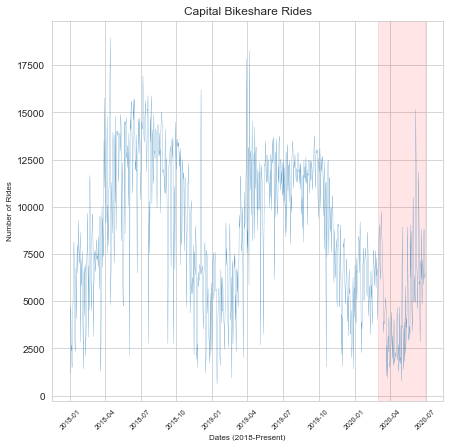

In [37]:
# plot number of rides over time
df.reset_index(level=0, inplace=True)
df['started_at'] = pd.to_datetime(df['started_at'])
df = df.set_index(['started_at'])
df_daily = df['number_rides'].resample('D').sum()

sns.set_style("whitegrid")
fig = plt.figure()
ax = plt.axes()
plt.title('Capital Bikeshare Rides', fontsize=12)
plt.ylabel('Number of Rides', fontsize=8)
plt.xlabel('Dates (2018-Present)', fontsize=8)
plt.xticks(rotation=45, fontsize=7) 
plt.axvspan(datetime(2020,3,1), datetime(2020,6,30), color='red', alpha=0.1)
plt.plot(df_daily.index, df_daily[:], linewidth=0.2)

# Compare Mar 2020 - Jun 2020 compared to 2018 and 2020 rides
#df = df[(df['started_at'].dt.month >= 1) & (df['started_at'].dt.month <= 2)]
#df['year'] = df['started_at'].apply(lambda x: x.year)
#df['month'] = df['started_at'].apply(lambda x: x.month)

#print(df.groupby('year')['number_rides'].sum())

# df['year'] = df['year'].astype('category')
# #df['start_station_name'] = df['start_station_name'].astype('category')
# df['start_station_name'] = df['start_station_name'].astype(str)

# # print sample of columns
# # df1 = df.iloc[:1000]
# # df2 = df.iloc[-1000:]

# df_grouped = df.groupby(['start_station_name', 'year'])['number_rides'].count().unstack()
# df_grouped.columns = df_grouped.columns.astype(list)
# df_grouped.columns = ['2018', '2019', '2020']
# df_grouped = df_grouped[(df_grouped['2019'] != 0) & (df_grouped['2020'] != 0)]
# #df_grouped = df_grouped[df_grouped.index.str.contains("Metro")]


# df_grouped['% Change 2019-2020'] = (df_grouped['2020'] - df_grouped['2019'])/df_grouped['2019'] * 100
# #df_grouped['% Change 2019-2020'] = df_grouped['% Change 2019-2020'].sort_values(ascending=False)
# df_grouped = df_grouped.sort_values(by ='% Change 2019-2020' , ascending=False)

# #print(np.mean(df_grouped['% Change 2019-2020']))
# #print(np.sum(df_grouped['2019']))
